# Research Question: To what extent did China's One-Child Policy (1979) cause a drop in fertility?

### PART 1: A comparative demographic study to Vietnam and South Korea

#### Authored By: Srisha Raj
#### Data Source: World Bank Group, [Fertility rate, total (births per woman)](https://data.worldbank.org/indicator/SP.DYN.TFRT.IN)


## Step 1: Load Data

In [2]:
#import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker


In [4]:
df_raw = pd.read_csv('API_SP.DYN.TFRT.IN_DS2_en_csv_v2_123473.csv', skiprows=4)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#creating sub-dataframes by country

china_df_raw = df_raw[df_raw["Country Name"] == "China"]
vietnam_df_raw = df_raw[df_raw["Country Name"] == "Viet Nam"]
south_korea_df_raw = df_raw[df_raw["Country Name"] == "Korea, Rep."]
south_korea_df_raw.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
126,"Korea, Rep.",KOR,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,5.994,5.803,5.562,5.334,5.068,4.887,...,1.172,1.052,0.977,0.918,0.837,0.808,0.778,0.721,NaN,NaN


For time series data, **.melt** is used to unpivot a table so that we can get all the years as one variable!

In this case, we want a column where it's just 'Year' and the corresponding Value would be 'Total Fertility Rate'.



In [9]:
china_df = china_df_raw.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Total Fertility Rate").dropna(subset=["Total Fertility Rate"])

vietnam_df = vietnam_df_raw.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Total Fertility Rate").dropna(subset=["Total Fertility Rate"])


south_korea_df = south_korea_df_raw.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Total Fertility Rate").dropna(subset=["Total Fertility Rate"])

In [11]:
china_df["Year"] = china_df["Year"].astype(int)
vietnam_df["Year"] = vietnam_df["Year"].astype(int)
south_korea_df["Year"] = south_korea_df["Year"].astype(int)

In [12]:
#dataset will be the dataframe with all 3 subframes combined and standardized
dataset = pd.concat([china_df, vietnam_df, south_korea_df], ignore_index=True)

In [13]:
dataset.to_csv("fertility_rates.csv", index=False)

# Step 2: Exploratory Data Analysis

### Side-by-Side Line Plot: China vs. Vietnam vs. South Korea

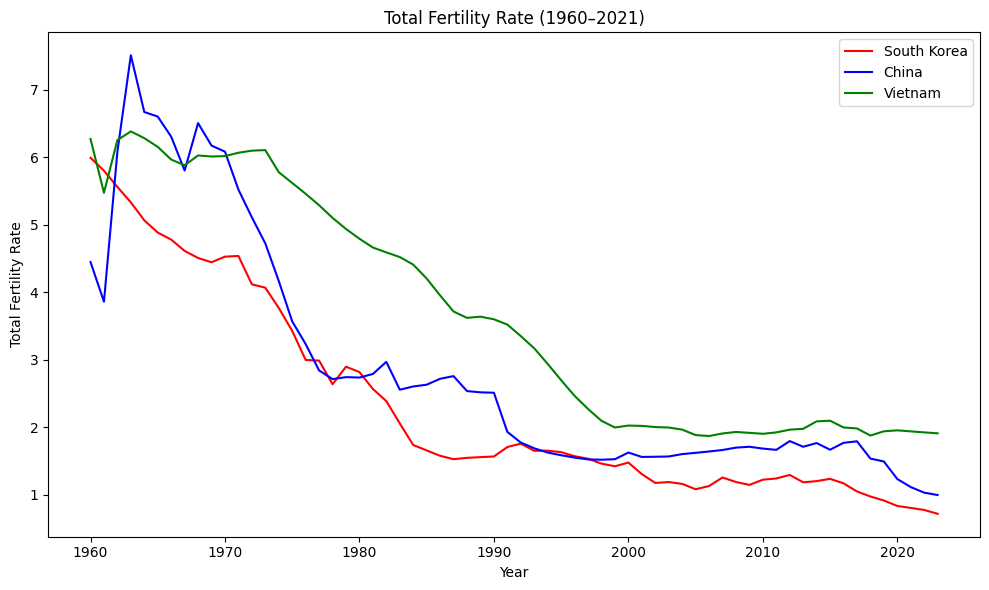

In [19]:
plt.figure(figsize=(10, 6))

loc = plticker.MultipleLocator(base=10)
ax = plt.gca()

sns.lineplot(data=south_korea_df, x="Year", y="Total Fertility Rate", ax=ax, label='South Korea', color='red')
sns.lineplot(data=china_df, x="Year", y="Total Fertility Rate", ax=ax, label='China', color='blue')
sns.lineplot(data=vietnam_df, x="Year", y="Total Fertility Rate", ax=ax, label='Vietnam', color='green')

ax.xaxis.set_major_locator(loc)
plt.title("Total Fertility Rate (1960–2021)")
plt.xlabel("Year")
plt.ylabel("Total Fertility Rate")


plt.legend()
plt.tight_layout()
plt.show()

#Step 3: OLS Regression Model for DiD (Differences in Differences)




In [20]:
import statsmodels.api as sm
#Both Time Series trends looks like exponential decay, so use log transformation and moving averages for OLS

In [22]:
#[insert country name]_df_USE for simpler OLS model
china_df_USE = china_df[["Country Name", "Year","Total Fertility Rate"]]
vietnam_df_USE = vietnam_df[["Country Name", "Year","Total Fertility Rate"]]
south_korea_df_USE = south_korea_df[["Country Name", "Year","Total Fertility Rate"]]

# Time Series Smoothing Technique: Moving Averages



## **1. CHINA**

In [38]:
#china_df_exp will be used for experimental purposes; china_df_exp operates similarly to china_df_USE (First Five rows dropped)
china_df_exp=china_df_USE.copy()

china_df_exp["ma_Fertility"] = china_df_exp["Total Fertility Rate"].rolling(window=5).mean()
china_df_exp = china_df_exp.dropna()

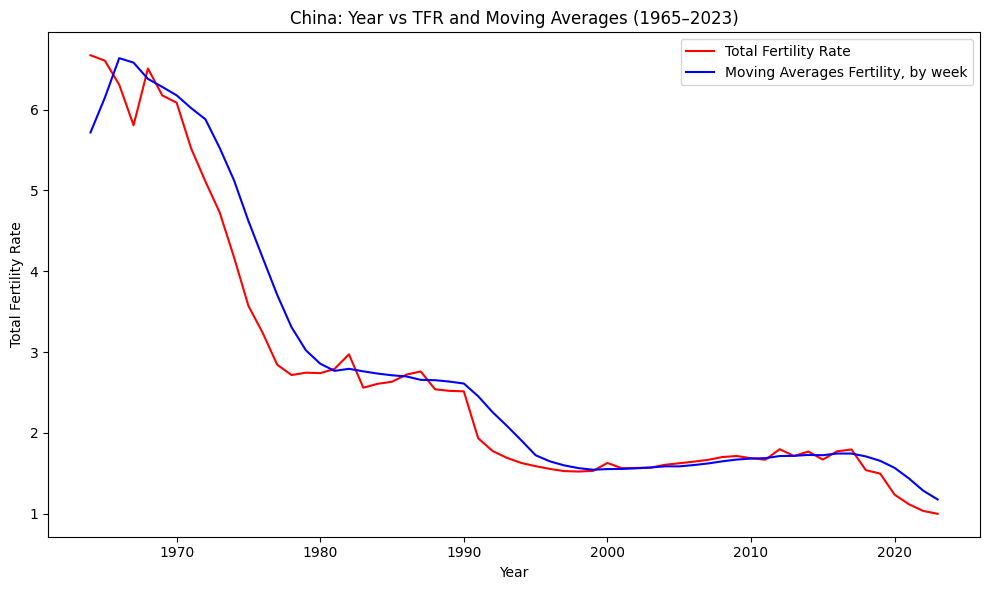

In [39]:
# @title China: Year vs TFR and Moving Average (TFR)

plt.figure(figsize=(10, 6))

loc = plticker.MultipleLocator(base=10)
ax = plt.gca()

sns.lineplot(data=china_df_exp, x="Year", y="Total Fertility Rate", ax=ax, label='Total Fertility Rate', color='red')
sns.lineplot(data=china_df_exp, x="Year", y="ma_Fertility", ax=ax, label='Moving Averages Fertility, by week', color='blue')

ax.xaxis.set_major_locator(loc)
plt.title("China: Year vs TFR and Moving Averages (1965–2023)")
plt.xlabel("Year")
plt.ylabel("Total Fertility Rate")


plt.legend()
plt.tight_layout()
plt.show()

Here we observe that using Moving Averages, the graph is not as sensitive to noise, and thus the trend is not overfitting as much. We will repeat this process for the other two countries.

## **2. Vietnam**

In [41]:
#vietnam_df_exp will be used for experimental purposes; vietnam_df_exp operates similarly to vietnam_df_USE (First Five rows dropped)
vietnam_df_exp=vietnam_df_USE.copy()

vietnam_df_exp["ma_Fertility"] = vietnam_df_exp["Total Fertility Rate"].rolling(window=5).mean()
vietnam_df_exp = vietnam_df_exp.dropna()

## **3. South Korea**

In [54]:
#south_korea_df_exp will be used for experimental purposes; south_korea_df_exp operates similarly to south_korea_df_USE (First Five rows dropped)
south_korea_df_exp=south_korea_df_USE.copy()

south_korea_df_exp["ma_Fertility"] = south_korea_df_exp["Total Fertility Rate"].rolling(window=5).mean()
south_korea_df_exp = south_korea_df_exp.dropna()

# DiD Variable Definitions - Experiment 1: Vietnam as counterfactual


*   TREATMENT: Whether Country is China (1) or Vietnam (0)
*   POST: Pre or Post Policy (1979)
*   DiD: Interaction Term based on if policy has been enacted in China

In [28]:
combined_df_v = pd.concat([china_df_exp, vietnam_df_exp], ignore_index=True).sort_values(by="Year").set_index("Year").reset_index()
combined_df_v["log_Fertility"] = np.log(combined_df_v["Total Fertility Rate"])
combined_df_v.head(4)

,Year,Country Name,Total Fertility Rate,ma_Fertility,log_Fertility
0,1964,China,6.672,5.7168,1.897920
1,1964,Viet Nam,6.285,6.1352,1.838166
2,1965,Viet Nam,6.156,6.1118,1.817427
3,1965,China,6.605,6.1476,1.887827


# Assessing Linear Fit for OLS model

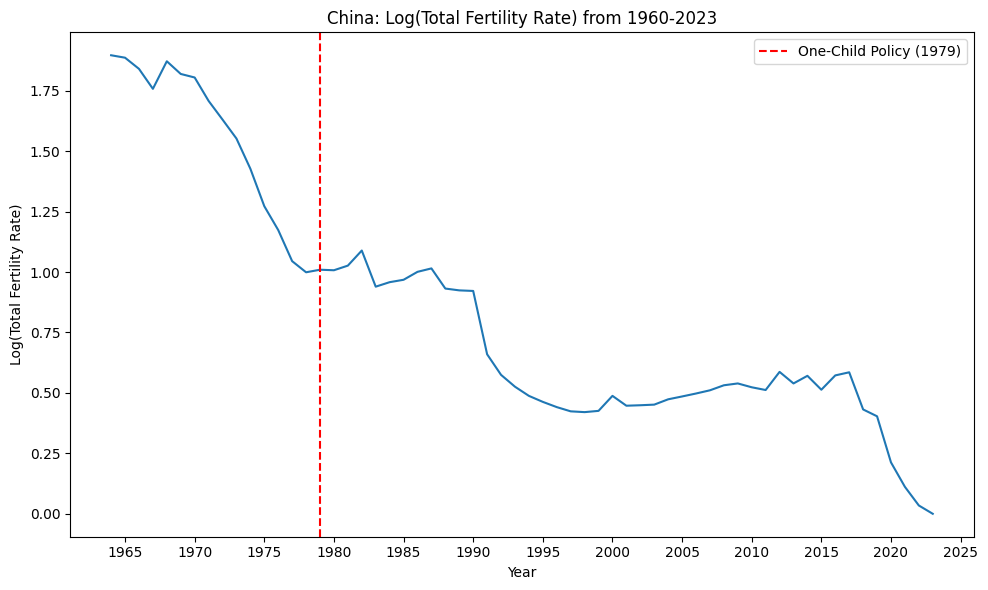

In [29]:
# @title China: Year vs Log(Total Fertility Rate)

plt.figure(figsize=(10, 6))
combined_df_china = combined_df_v[combined_df_v["Country Name"] == "China"]
ax = sns.lineplot(data=combined_df_china, x="Year", y="log_Fertility")

plt.axvline(x=1979, color='red', linestyle='--', label='One-Child Policy (1979)')
loc = plticker.MultipleLocator(base=5)
ax.xaxis.set_major_locator(loc)



plt.title('China: Log(Total Fertility Rate) from 1960-2023')
plt.xlabel('Year')
plt.ylabel('Log(Total Fertility Rate)')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Treatment: 1 if China, 0 if Vietnam
combined_df_v["Treatment"] = combined_df_v["Country Name"].apply(lambda x: 1 if x == "China" else 0)

# Post: 1 if year >= 1979
combined_df_v["Post"] = combined_df_v["Year"].apply(lambda x: 1 if x >= 1979 else 0)

# DiD: interaction term
combined_df_v["DiD"] = combined_df_v["Treatment"] * combined_df_v["Post"]

combined_df_v.head(4)

,Year,Country Name,Total Fertility Rate,ma_Fertility,log_Fertility,Treatment,Post,DiD
0,1964,China,6.672,5.7168,1.897920,1,0,0
1,1964,Viet Nam,6.285,6.1352,1.838166,0,0,0
2,1965,Viet Nam,6.156,6.1118,1.817427,0,0,0
3,1965,China,6.605,6.1476,1.887827,1,0,0


# Regression with log_Fertility

In [45]:
X = combined_df_v[["Treatment", "Post", "DiD"]]
X = sm.add_constant(X)
y = combined_df_v["log_Fertility"]

model_v = sm.OLS(y, X).fit()
print(model_v.summary())

                            OLS Regression Results                            
Dep. Variable:          log_Fertility   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     83.98
Date:                Sun, 07 Sep 2025   Prob (F-statistic):           6.03e-29
Time:                        04:00:33   Log-Likelihood:                -20.530
No. Observations:                 120   AIC:                             49.06
Df Residuals:                     116   BIC:                             60.21
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7664      0.075     23.426      0.0

# Regression with fertility

In [57]:
X = combined_df_v[["Treatment", "Post", "DiD"]]
X = sm.add_constant(X)
y = combined_df_v["Total Fertility Rate"]

model_v = sm.OLS(y, X).fit()
print(model_v.summary())

                             OLS Regression Results                             
Dep. Variable:     Total Fertility Rate   R-squared:                       0.736
Model:                              OLS   Adj. R-squared:                  0.729
Method:                   Least Squares   F-statistic:                     107.7
Date:                  Sun, 07 Sep 2025   Prob (F-statistic):           2.19e-33
Time:                          04:38:06   Log-Likelihood:                -151.98
No. Observations:                   120   AIC:                             312.0
Df Residuals:                       116   BIC:                             323.1
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8592      0.225

# DiD Variable Definitions - Experiment 2: South Korea as counterfactual


*   TREATMENT: Whether Country is China (1) or South Korea (0)
*   POST: Pre or Post Policy (1979)
*   DiD: Interaction Term based on if policy has been enacted in China

In [49]:
combined_df_sk = pd.concat([china_df_USE, south_korea_df_USE], ignore_index=True).sort_values(by="Year").set_index("Year").reset_index()
combined_df_sk["log_Fertility"] = np.log(combined_df_sk["Total Fertility Rate"])
combined_df_sk.head(4)

# Treatment: 1 if China, 0 if South Korea
combined_df_sk["Treatment"] = combined_df_sk["Country Name"].apply(lambda x: 1 if x == "China" else 0)

# Post: 1 if year >= 1979
combined_df_sk["Post"] = combined_df_sk["Year"].apply(lambda x: 1 if x >= 1979 else 0)

# DiD: interaction term
combined_df_sk["DiD"] = combined_df_sk["Treatment"] * combined_df_sk["Post"]

combined_df_sk.head(4)

,Year,Country Name,Total Fertility Rate,log_Fertility,Treatment,Post,DiD
0,1960,China,4.451,1.493129,1,0,0
1,1960,"Korea, Rep.",5.994,1.790759,0,0,0
2,1961,"Korea, Rep.",5.803,1.758375,0,0,0
3,1961,China,3.863,1.351444,1,0,0


# Regression with log_Fertility

In [52]:
X = combined_df_sk[["Treatment", "Post", "DiD"]]
X = sm.add_constant(X)
y = combined_df_sk["log_Fertility"]

model_sk = sm.OLS(y, X).fit()
print(model_sk.summary())

                            OLS Regression Results                            
Dep. Variable:          log_Fertility   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     132.2
Date:                Sun, 07 Sep 2025   Prob (F-statistic):           1.85e-38
Time:                        04:02:28   Log-Likelihood:                -19.847
No. Observations:                 128   AIC:                             47.69
Df Residuals:                     124   BIC:                             59.10
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4636      0.066     22.223      0.0

# Regression with ma_Fertility

In [55]:
combined_df_sk["ma_Fertility"] = combined_df_sk["Total Fertility Rate"].rolling(window=5).mean()
combined_df_sk = combined_df_sk.dropna()

In [56]:
X = combined_df_sk[["Treatment", "Post", "DiD"]]
X = sm.add_constant(X)
y = combined_df_sk["ma_Fertility"]

model_sk = sm.OLS(y, X).fit()
print(model_sk.summary())

                            OLS Regression Results                            
Dep. Variable:           ma_Fertility   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     194.6
Date:                Sun, 07 Sep 2025   Prob (F-statistic):           6.37e-46
Time:                        04:37:43   Log-Likelihood:                -121.66
No. Observations:                 124   AIC:                             251.3
Df Residuals:                     120   BIC:                             262.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7963      0.159     30.141      0.0

The regressions performed from above average to moderately strong (R = 0.83). However, this alone does not confirm a causal relationship. Further work is needed to develop a more refined control variable that accurately simulates China in a counterfactual setting.

While this is a nearly-impossible task, we will explore a method commonly used in social science research: Synthetic Control Method.